# House Price Prediction Using JAX (Flax & Optax)

This notebook builds a neural network using JAX with Flax and Optax to predict house prices. An extra cell uses the correlation matrix to select the top five features most correlated with SalePrice.

In [7]:
pip install jax


[notice] A new release of pip is available: 24.3.1 -> 25.0.1
[notice] To update, run: python -m pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [8]:
pip install flax


[notice] A new release of pip is available: 24.3.1 -> 25.0.1
[notice] To update, run: python -m pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [9]:
import numpy as np
import pandas as pd
import os

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error

import jax
import jax.numpy as jnp

import flax.linen as nn
from flax.training import train_state
import optax

import matplotlib.pyplot as plt
%matplotlib inline

# For reproducibility
np.random.seed(42)
jax.config.update("jax_platform_name", "cpu")  # Change to 'gpu' if available

print('JAX version:', jax.__version__)

JAX version: 0.5.0


## 1. Load the Data

Replace the placeholder paths with the actual file paths for `train.csv` and `test.csv`.

In [10]:
# Replace these paths with the actual file paths
train_path = 'train.csv'
test_path = 'test.csv'

train_df = pd.read_csv(train_path)
test_df = pd.read_csv(test_path)

print('Train shape:', train_df.shape)
print('Test shape:', test_df.shape)

Train shape: (1000, 81)
Test shape: (460, 80)


## 2. Data Preprocessing

Fill missing values, drop the `Id` column, separate out the target `SalePrice`, and one-hot encode categorical features.

In [11]:
def fill_missing_values(df):
    # Fill numeric columns with the median
    num_cols = df.select_dtypes(include=['int64', 'float64']).columns
    for col in num_cols:
        df[col].fillna(df[col].median(), inplace=True)
    
    # Fill categorical columns with mode
    cat_cols = df.select_dtypes(include=['object']).columns
    for col in cat_cols:
        df[col].fillna(df[col].mode()[0], inplace=True)
    return df

# Process training data
train_df = fill_missing_values(train_df.copy())

# Save and drop the Id column
train_ids = train_df['Id']
train_df.drop('Id', axis=1, inplace=True)

# Separate target variable and features
y = train_df['SalePrice']
X = train_df.drop('SalePrice', axis=1)

# Convert categorical features to dummy variables
X = pd.get_dummies(X, drop_first=True)

print('Processed training features shape:', X.shape)

Processed training features shape: (1000, 230)


/tmp/ipykernel_11165/966995088.py:5: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df[col].fillna(df[col].median(), inplace=True)
/tmp/ipykernel_11165/966995088.py:5: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try us

## 2.1 Feature Selection

Compute the correlation matrix and select the top five features most correlated with SalePrice.

In [12]:
# Compute correlation matrix only on numeric columns (including SalePrice)
numeric_df = train_df.select_dtypes(include=[np.number])
corr_matrix = numeric_df.corr()

# Get top 5 features with highest absolute correlation with SalePrice (excluding SalePrice itself)
top_features = corr_matrix['SalePrice'].abs().sort_values(ascending=False).iloc[1:6].index.tolist()
print('Top 5 features selected:', top_features)

# Then, update X to keep only these features
X = X[top_features]
print('X shape after feature selection:', X.shape)

Top 5 features selected: ['OverallQual', 'GrLivArea', 'GarageCars', 'GarageArea', 'TotalBsmtSF']
X shape after feature selection: (1000, 5)


### 2.2 Train-Validation Split and Scaling

Split the data (80% training, 20% validation) and scale the features.

In [13]:
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.20, random_state=42)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)

print('X_train_scaled shape:', X_train_scaled.shape)
print('X_val_scaled shape:', X_val_scaled.shape)

X_train_scaled shape: (800, 5)
X_val_scaled shape: (200, 5)


## 3. Convert Data to JAX Arrays

Convert the numpy arrays to JAX arrays.

In [14]:
X_train_jax = jnp.array(X_train_scaled)
y_train_jax = jnp.array(y_train.values).reshape(-1, 1)

X_val_jax = jnp.array(X_val_scaled)
y_val_jax = jnp.array(y_val.values).reshape(-1, 1)

print('X_train_jax shape:', X_train_jax.shape)
print('X_val_jax shape:', X_val_jax.shape)

X_train_jax shape: (800, 5)
X_val_jax shape: (200, 5)


## 4. Define the JAX Model Using Flax

Define a neural network with two hidden layers (128 then 64 nodes) and dropout.

In [15]:
class HousePriceNet(nn.Module):
    dropout_rate: float = 0.2
    
    @nn.compact
    def __call__(self, x, training):
        x = nn.Dense(128)(x)
        x = nn.relu(x)
        x = nn.Dropout(rate=self.dropout_rate)(x, deterministic=not training)
        x = nn.Dense(64)(x)
        x = nn.relu(x)
        x = nn.Dropout(rate=self.dropout_rate)(x, deterministic=not training)
        x = nn.Dense(1)(x)
        return x

model = HousePriceNet()

rng = jax.random.PRNGKey(0)
dummy_input = jnp.ones((X_train_jax.shape[0], X_train_jax.shape[1]))
params = model.init(rng, dummy_input, training=True)['params']

print('Model parameters initialized.')

Model parameters initialized.


## 5. Define the Training State and Loss Function

Create a training state using Optax’s Adam optimizer and define an MSE loss.

In [16]:
class TrainState(train_state.TrainState):
    pass

def mse_loss(params, batch, rng, training):
    inputs, targets = batch
    preds = model.apply({'params': params}, inputs, training=training, rngs={'dropout': rng})
    loss = jnp.mean((preds - targets) ** 2)
    return loss

learning_rate = 0.001
tx = optax.adam(learning_rate)
state = TrainState.create(apply_fn=model.apply, params=params, tx=tx)

print('Training state created.')

Training state created.


## 6. Define Training and Evaluation Steps

Define functions for a training step (with gradient updates) and an evaluation step.

In [17]:
@jax.jit
def train_step(state, batch, rng):
    grad_fn = jax.value_and_grad(mse_loss)
    loss, grads = grad_fn(state.params, batch, rng, True)
    state = state.apply_gradients(grads=grads)
    return state, loss

@jax.jit
def eval_step(params, batch, rng):
    loss = mse_loss(params, batch, rng, False)
    return loss

def compute_rmse(params, inputs, targets, rng):
    preds = model.apply({'params': params}, inputs, training=False, rngs={'dropout': rng})
    mse = jnp.mean((preds - targets) ** 2)
    return jnp.sqrt(mse)

## 7. Training Loop

Train the model for 100 epochs, recording training and validation loss.

In [18]:
num_epochs = 100
train_losses = []
val_losses = []

for epoch in range(num_epochs):
    rng, step_rng = jax.random.split(rng)
    batch = (X_train_jax, y_train_jax)
    state, loss = train_step(state, batch, step_rng)
    train_losses.append(loss.item())
    
    val_loss = eval_step(state.params, (X_val_jax, y_val_jax), step_rng)
    val_losses.append(val_loss.item())
    
    if (epoch + 1) % 10 == 0:
        rmse = compute_rmse(state.params, X_val_jax, y_val_jax, step_rng)
        print(f"Epoch {epoch+1}/{num_epochs} - Train Loss: {loss.item():.4f}, Val Loss: {val_loss.item():.4f}, Val RMSE: {rmse.item():.4f}")

Epoch 10/100 - Train Loss: 41067290624.0000, Val Loss: 34066880512.0000, Val RMSE: 184572.1562
Epoch 20/100 - Train Loss: 41066487808.0000, Val Loss: 34066178048.0000, Val RMSE: 184570.2500
Epoch 30/100 - Train Loss: 41065472000.0000, Val Loss: 34065221632.0000, Val RMSE: 184567.6562
Epoch 40/100 - Train Loss: 41063956480.0000, Val Loss: 34063939584.0000, Val RMSE: 184564.1875
Epoch 50/100 - Train Loss: 41062084608.0000, Val Loss: 34062256128.0000, Val RMSE: 184559.6250
Epoch 60/100 - Train Loss: 41059471360.0000, Val Loss: 34060060672.0000, Val RMSE: 184553.6719
Epoch 70/100 - Train Loss: 41056264192.0000, Val Loss: 34057236480.0000, Val RMSE: 184546.0312
Epoch 80/100 - Train Loss: 41051996160.0000, Val Loss: 34053656576.0000, Val RMSE: 184536.3281
Epoch 90/100 - Train Loss: 41047191552.0000, Val Loss: 34049183744.0000, Val RMSE: 184524.2031
Epoch 100/100 - Train Loss: 41040384000.0000, Val Loss: 34043688960.0000, Val RMSE: 184509.3125


## 8. Evaluate the Model on Validation Set

Compute the final RMSE on the validation set.

In [19]:
val_rmse = compute_rmse(state.params, X_val_jax, y_val_jax, rng)
print('Final Validation RMSE:', val_rmse.item())

Final Validation RMSE: 184509.3125


## 9. Prepare Test Data and Make Predictions

Process the test data and obtain predictions.

In [20]:
# Process test data
test_df = fill_missing_values(test_df.copy())

# Save the test Ids and drop the 'Id' column
test_ids = test_df['Id']
test_df.drop('Id', axis=1, inplace=True)

# Convert categorical features to dummy variables
test_df = pd.get_dummies(test_df, drop_first=True)

# Align test dataframe to training features (fill missing columns with 0)
test_df = test_df.reindex(columns=X.columns, fill_value=0)

# Scale test features
test_scaled = scaler.transform(test_df)
test_jax = jnp.array(test_scaled)

# Predict on test data
preds_test = model.apply({'params': state.params}, test_jax, training=False, rngs={'dropout': rng})
preds_test = np.array(preds_test).flatten()

print('Test predictions shape:', preds_test.shape)

Test predictions shape: (460,)


/tmp/ipykernel_11165/966995088.py:5: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df[col].fillna(df[col].median(), inplace=True)
/tmp/ipykernel_11165/966995088.py:5: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try us

## 10. Save the Predictions

Save the predictions to a CSV file with columns **ID** and **SALEPRICE**.

In [21]:
predictions_df = pd.DataFrame({
    'ID': test_ids,
    'SALEPRICE': preds_test
})

# Replace with your desired output path
predictions_csv_path = 'predictions_jax_v2.csv'
predictions_df.to_csv(predictions_csv_path, index=False)

print('Predictions saved to', predictions_csv_path)

Predictions saved to predictions_jax_v2.csv


## 11. (Optional) Plot Training and Validation Loss

Plot the loss curves over the training epochs.

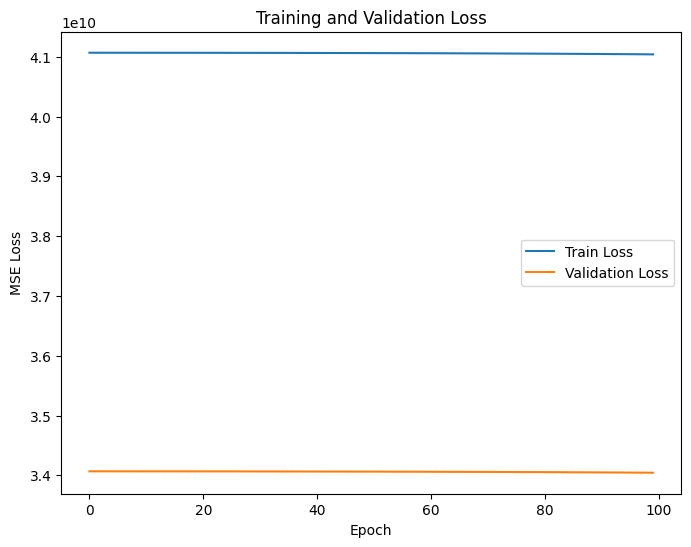

In [22]:
plt.figure(figsize=(8,6))
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('MSE Loss')
plt.legend()
plt.title('Training and Validation Loss')
plt.show()

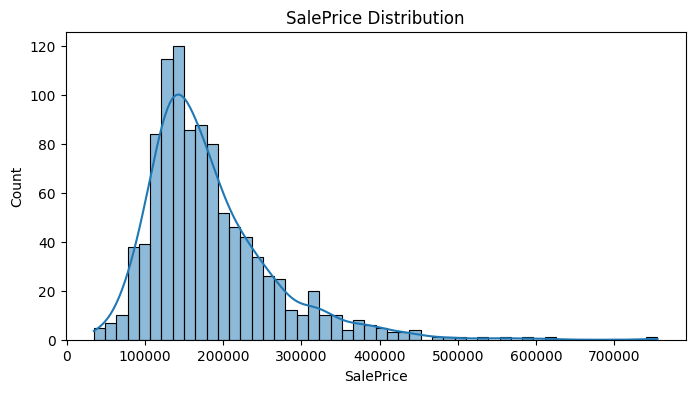

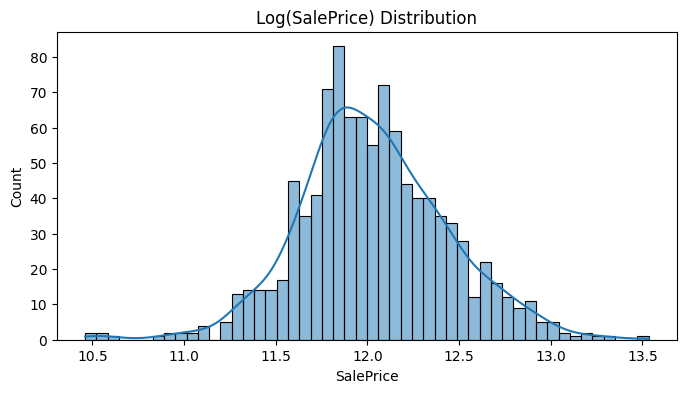

In [23]:
import seaborn as sns
import matplotlib.pyplot as plt

# Plot distribution of SalePrice (or log(SalePrice))
plt.figure(figsize=(8, 4))
sns.histplot(train_df['SalePrice'], bins=50, kde=True)
plt.title('SalePrice Distribution')
plt.show()

# If using log transformation:
plt.figure(figsize=(8, 4))
sns.histplot(np.log(train_df['SalePrice']), bins=50, kde=True)
plt.title('Log(SalePrice) Distribution')
plt.show()
